<a href="https://colab.research.google.com/github/domini4/Reinforcement-Learning/blob/main/Deep_Q_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q Network

---

DQN to solve OpenAI frogger environment

### 1. Install necessary libraries and import packages

---



In [ ]:
!apt-get update
!apt-get install xvfb
!apt-get install x11-utils
!apt-get install ffmpeg
!apt-get install python-opengl
!pip -q install gym pyvirtualdisplay pygame


# Environment
import gym # OpenAI gym
import frogger_env
gym.logger.set_level(40) # suppress warnings on gym

# Models and computation
import torch # will use pyTorch to handle NN
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from collections import deque
import random
from random import sample
from random import choices

# Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
import base64

# IO
from pathlib import Path
import os

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [577 kB]
Get:

Let's define a simple helper function for visualization of episodes


# 2. Define the Q Network

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Simple NN with three hidden layers
class QNetwork(nn.Module):
    def __init__(self, s_size,  a_size, fc1_units, fc2_units, fc3_units):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(s_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, a_size)

    def forward(self, state):
        """Perform forward propagation."""

        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x,
                             device=device,
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

# 4. DQN Agent

In [ ]:
class DQNAgent():
    def __init__(self, state_size, action_size, batch_size, epochs, lr, eps, decay):
        """
        Initialize a DQNAgent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            batch_size (int):  minibatch size
            epochs (int):  training iterations
            lr (float): learning rate
            eps (float): exploration factor
            decay (float): exploration decay
        """
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.eps = eps
        self.decay = decay
        self.countst = 0

        # Q-Network and target network initialize
        self.qnetwork = QNetwork(state_size, action_size, 64, 64, 32).to(device)
        self.targetnet = QNetwork(state_size, action_size, 64, 64, 32).to(device)
        self.targetnet.load_state_dict(self.qnetwork.state_dict())
        # Optimizer
        self.optimizer = optim.RMSprop(self.qnetwork.parameters(), lr=self.lr)

    def learn(self, experiences, TAU):
        """
        Update q-network parameters using a batch of experience tuples.

        Params
        ======
        experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done)
        tau (float): soft update interpolation parameter
        """
        states, actions, rewards, next_states, dones = experiences
        batch_size = len(dones)


        # Get max Q values for next states from target net
        q_next_states = self.targetnet(next_states).detach()
        q_max_next_states = q_next_states.max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        q_targets = rewards + (self.gamma * q_max_next_states * (1 - dones))

        # Get predicted Q values
        q_predicted = self.qnetwork(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(q_predicted, q_targets)
        #td_errors = q_predicted - q_targerts
        #loss = td_errors.pow(2).mul(0.5).mean() #equivalent

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork, self.targetnet, TAU)

    def soft_update(self, local_model, target_model, tau):
        """
        Soft update model parameters

        Params
        ======
            local_model (ptorch model): weights copied from
            target_model (pytorch model): weight copied to
            tau (float): interpolation parameter
        """
        #### soft update model parameters ######
        # soft max update algorith from below link
        # https://medium.com/@unnatsingh/deep-q-network-with-pytorch-d1ca6f40bfda
        for target_param,local_param in zip(target_model.parameters(),local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def epsilon_greedy_action(self, state):
        """
        Returns action for given state.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon
        """
        with torch.no_grad():
            q_values = self.qnetwork(state).cpu().detach().data.numpy().squeeze()

        if np.random.rand() > self.eps:
            action = np.argmax(q_values)
        else:
            action = np.random.randint(len(q_values))

        return action

    def greedy_action(self, state):
        """
        Returns the greedy action.

        Params
        ======
            state (array_like): current state
        """
        with torch.no_grad():
            q_values = self.qnetwork(state).cpu().detach().data.numpy().squeeze()
        return np.argmax(q_values)

    def collect_experience(self, env, state):
        """
        Collect an experience and add it to the experiences dataset.
        Returns the new state and whether it is terminal.

        Params
        ======
            env: the environment
            state (array_like): current state
            eps (float): epsilon
        """
        action = self.epsilon_greedy_action(state)
        new_state, reward, is_terminal, info = env.step(action)
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        is_failure = is_terminal and not is_truncated
        experience = (state, action, reward, new_state, float(is_failure))
        self.experiences.append(experience)

        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.countst += 1
#       Linear decay of eps. Eps stays 1.0 for the first 10% of steps. This is to encourage exploration
        if self.countst > (max_steps/10) and self.eps > 0.2:
            self.eps -= self.decay

        return new_state, is_terminal

    def evaluate(self, env, n_rollouts=1):
        """
        Returns the mean + std score obtained by executing the greedy policy for a fixed number of rollouts.

        Params
        ======
            env: the environment
            n_rollouts (int): the number of rollouts to be performed
        """
        rewards = []
        for _ in range(n_rollouts):
            state, done = env.reset(), False
            rewards.append(0)
            while not done:
                action = self.greedy_action(state)
                state, reward, done, _ = env.step(action)
                rewards[-1] += reward
        return np.mean(rewards), np.std(rewards)

    def train(self, env, seed, gamma, max_episodes, max_steps, goal_mean_100_reward, TAU):
        """
        Training the agent.
        Returns a list of (total number steps, average training reward over last 100 episodes,
                           average evaluation reward over last 100 episodes) per episode

        Params
        ======
            env: open ai environment
            seed (int): a random of fixed seed number
            gamma (float): the discount factor
            max_episodes (int): total number of episodes
            max_steps (int): total number of allowed steps
            goal_mean_100_reward: the threshold, as measured by average evaluation reward over 100 episodes,
                                  denoting whether the problem is solved
            tau (float): soft update interpolation parameter
        """

        self.seed = seed
        self.gamma = gamma
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)

        self.episode_reward = []
        self.evaluation_scores = []
        self.experiences = deque(maxlen=30000)    #replay buffer
        self.episode_timestep = []
        self.noexp = 0

        mean_100_eval_score = 0.0

        # store the total steps, the mean reward over the last 100 steps,
        # and the mean evaluation reward over the last 100 episodes
        result = np.empty((max_episodes, 3))
        result[:] = np.nan
#        eps = 1.0
        for episode in range(1, max_episodes + 1):

            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)

            while True:
                state, is_terminal = self.collect_experience(env, state)
                self.noexp += 1


                if len(self.experiences) >= self.batch_size:
                    #experiences = np.array(self.experiences)
                    experiences = np.array(choices(self.experiences, k=self.batch_size))


                    batches = [np.vstack(e) for e in experiences.T]
                    states, actions, rewards, new_states, is_terminals = batches

                    # load the dataset to the device
                    states = torch.from_numpy(states).float().to(device)
                    actions = torch.from_numpy(actions).long().to(device)
                    new_states = torch.from_numpy(new_states).float().to(device)
                    rewards = torch.from_numpy(rewards).float().to(device)
                    is_terminals = torch.from_numpy(is_terminals).float().to(device)
                    experiences = (states, actions, rewards, new_states, is_terminals)

                    for _ in range(self.epochs):
                        self.learn(experiences, TAU)
#                    self.experiences.clear()

                # if (self.noexp%400) == 0:
                #     self.targetnet.load_state_dict(self.qnetwork.state_dict())

                if is_terminal:
                    break

            # bookkeeping
            evaluation_score, _ = self.evaluate(env) # evaluate using the greedy policy

            total_steps = int(np.sum(self.episode_timestep)) # total number of environment steps
            self.evaluation_scores.append(evaluation_score)

            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])

            result[episode-1] = total_steps, mean_100_reward, mean_100_eval_score

            print('Episode: {:d}, Total Steps: {:d}, Train_reward: {:.2f}, Eval_reward: {:.2f}'.format(episode-1,total_steps,\
                  mean_100_reward, mean_100_eval_score))

            # the problem considered solved if the average score over 100 consecutive trials is above
            #goal_mean_100_reward
            training_is_over = mean_100_eval_score >= goal_mean_100_reward or \
                               total_steps >= max_steps
            if training_is_over:
                if total_steps >= max_steps: print('--> reached_max_steps')
                if mean_100_eval_score >= goal_mean_100_reward:
                    print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode-1, mean_100_eval_score))
                break

        save_checkpoint(self.qnetwork,'dqn_domini4_'+str(seed)+'.pt',1)
        return result

In [ ]:
from google.colab import drive
from google.colab import files

def save_checkpoint(model, filename, mode=0):
    """
    Save a model to a file in your colab space

    Parameters
    ----------
    model: your Q network
    filename: the name of the checkpoint file
    mode (int): determines where to store the file
                --> 0: collab space 1: Google Drive
    """
    if mode == 1:
      drive.mount('/content/gdrive')
      path = F"/content/gdrive/My Drive/{filename}"
      torch.save(model.state_dict(), path)
    else:
      torch.save(model.state_dict(), filename)

def export_to_local_drive(filename):
    """
    Download a file to your local machine

    Parameters
    ----------
    filename: the name of the file
    """
    files.download(filename)



# 4. Train with DQN

In [ ]:
env = gym.make('frogger-v0')                          #set environment
batch_size = 32                                       #batch size for training
epochs = 5                                            #number of training epochs
lr = 1e-4                                             #neural network learning rate
gamma = 0.9                                           #future rewards discount factor
TAU = 1e-3                                            #soft update interpolation factor
max_episodes = 10000                                  #maximum number of training episodes
max_steps = 30000                                     #maximum number of training steps
eps = 1.0                                             #exploration factor
decay = eps/max_steps                                 #exploration decay
#goal_mean_100_reward = env.spec.reward_threshold     #set goal mean reward to env reward threshold
goal_mean_100_reward = 1.3                            #manually set mean reward threshold

seed = 12                                             #set seed
env.seed(seed)
agent = DQNAgent(env.observation_space.shape[0], env.action_space.n, batch_size, epochs, lr, eps, decay)
result = agent.train(env, seed, gamma, max_episodes, max_steps, goal_mean_100_reward, TAU)
env.close()

del env


Episode: 0, Total Steps: 4, Train_reward: -0.01, Eval_reward: -0.47
Episode: 1, Total Steps: 10, Train_reward: -0.25, Eval_reward: -0.48


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Episode: 2, Total Steps: 40, Train_reward: -0.17, Eval_reward: -0.32
Episode: 3, Total Steps: 63, Train_reward: -0.13, Eval_reward: -0.24
Episode: 4, Total Steps: 76, Train_reward: -0.20, Eval_reward: -0.20
Episode: 5, Total Steps: 87, Train_reward: -0.25, Eval_reward: -0.24
Episode: 6, Total Steps: 100, Train_reward: -0.22, Eval_reward: -0.05
Episode: 7, Total Steps: 109, Train_reward: -0.25, Eval_reward: -0.04
Episode: 8, Total Steps: 124, Train_reward: -0.28, Eval_reward: -0.04
Episode: 9, Total Steps: 128, Train_reward: -0.25, Eval_reward: -0.08
Episode: 10, Total Steps: 140, Train_reward: -0.27, Eval_reward: -0.08
Episode: 11, Total Steps: 156, Train_reward: -0.29, Eval_reward: 0.02
Episode: 12, Total Steps: 169, Train_reward: -0.27, Eval_reward: 0.02
Episode: 13, Total Steps: 198, Train_reward: -0.25, Eval_reward: 0.02
Episode: 14, Total Steps: 203, Train_reward: -0.27, Eval_reward: 0.01
Episode: 15, Total Steps: 209, Train_reward: -0.28, Eval_reward: 0.01
Episode: 16, Total Step

### 4. Plot the Reward

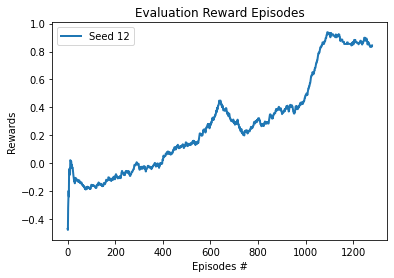

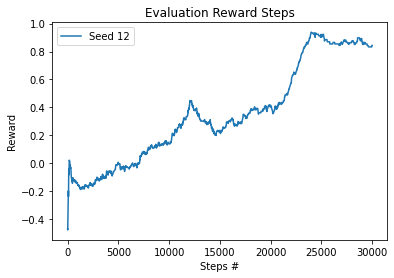

In [ ]:
dqn_steps, dqn_r, dqn_score = result.T

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
plt.plot(dqn_score, linewidth=2, label='Seed 12')
plt.ylabel('Rewards')
plt.xlabel('Episodes #')
leg = plt.legend();
ax1.set_title('Evaluation Reward Episodes')


fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
plt.plot(dqn_steps, dqn_score, label='Seed 12')
plt.ylabel('Reward')
plt.xlabel('Steps #')
leg = plt.legend();
ax2.set_title('Evaluation Reward Steps')

plt.show()

### 5. Test the Policy!

In [ ]:
display = Display(visible=0, size=(600, 400))
display.start()

def show_video(path):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [ ]:
env = gym.make('frogger-v0')
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)
state = env.reset()
done = False
rev = 0
while not done:
    action = agent.greedy_action(state)
    state, reward, done, _ = env.step(action)
    rev += reward
print(rev)
env.close()
show_video('./video')

del env

Origin:  [0.0, 0.0]
world_width:  50.0
world_height:  50.0
Screen:  <Surface(600x600x32 SW)>
1.11
